In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf

2022-04-01 15:51:37.361596: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-01 15:51:37.361661: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
df = pd.read_parquet("../data/processed/outlier_removed.parquet")

In [5]:
GENERATE_SPEED_ANGLE = True

weather_cols = [col for col in df.columns if col.startswith(("UGRD", "VGRD"))]

df = df.set_index("forecast_dt")[["rt_plant_id", "production", *weather_cols]]

if GENERATE_SPEED_ANGLE:
    for box in ["SW", "NW", "NE", "SE"]:
        df[f"speed_{box}"] = np.sqrt(np.square(df[f"UGRD_80.m.above.ground.{box}"]) + np.square(df[f"VGRD_80.m.above.ground.{box}"]))
        df[f"angle_{box}"] = np.arctan(df[f"UGRD_80.m.above.ground.{box}"] / df[f"VGRD_80.m.above.ground.{box}"])
        
time_indices = sorted(df.index.unique())
train_ratio = 0.8
valid_ratio = 0.1

train_indices = time_indices[:int(len(time_indices) * train_ratio)]
valid_indices = time_indices[int(len(time_indices) * train_ratio):int(len(time_indices) * (train_ratio + valid_ratio))]
test_indices = time_indices[int(len(time_indices) * (train_ratio + valid_ratio)):]

train_df = df.loc[train_indices, :]
valid_df = df.loc[valid_indices, :]
test_df = df.loc[test_indices, :]

PLANTS = sorted(df.rt_plant_id.unique())

def expand_plant_dimension(df):
    n_loc = len(PLANTS)
    n_time = df.index.nunique()
    cols = [col for col in df.columns if col != "rt_plant_id"]
    n_cols = len(cols)

    df_np = np.zeros((n_loc, n_time, n_cols))
    for i, plant_id in enumerate(PLANTS):
        df_np[i, :, :] = df[df.rt_plant_id == plant_id][cols].values
    return df_np

train_df_np = expand_plant_dimension(train_df)
valid_df_np = expand_plant_dimension(valid_df)
test_df_np = expand_plant_dimension(test_df)

from sklearn.preprocessing import MinMaxScaler
from pathlib import Path

scalers = {}
for i, plant in enumerate(PLANTS):
    scalers[plant] = MinMaxScaler()
    # train_df = pd.DataFrame(scaler.fit_transform(train_df), index=train_df.index, columns=train_df.columns)
    train_df_np[i, :, :] = scalers[plant].fit_transform(train_df_np[i, :, :])
    valid_df_np[i, :, :] = scalers[plant].transform(valid_df_np[i, :, :])
    test_df_np[i, :, :] = scalers[plant].transform(test_df_np[i, :, :])

# valid_df[valid_df["rt_plant_id"] == PLANTS[0]].iloc[0]
# scalers[PLANTS[0]].inverse_transform(valid_df_np[0])[0]

In [6]:
SELECTED_PLANT = 3
SELECTED_PLANT_ID = PLANTS[SELECTED_PLANT]

columns = [col for col in train_df.columns if col != "rt_plant_id"]

train_df_pd_0 = pd.DataFrame(train_df_np[SELECTED_PLANT], index=train_indices, columns=columns) 
valid_df_pd_0 = pd.DataFrame(valid_df_np[SELECTED_PLANT], index=valid_indices, columns=columns) 
test_df_pd_0 = pd.DataFrame(test_df_np[SELECTED_PLANT], index=test_indices, columns=columns) 


In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt

class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=valid_df, test_df=test_df,
                 label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels


    def plot(self, model=None, plot_col='production', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                    label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)
        ds = ds.map(self.split_window)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

In [14]:
MAX_EPOCHS = 40

def compile_and_fit(model, window, patience=8):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min', 
                                                    verbose=1,
                                                    restore_best_weights=True)

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()]) # tf.metrics.MeanAbsolutePercentageError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history


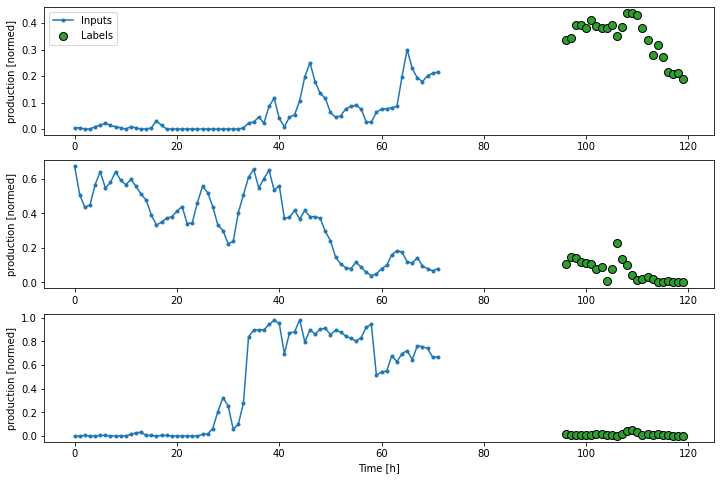

In [21]:
OUT_STEPS = 24
num_features = 16

multi_window = WindowGenerator(
    train_df=train_df_pd_0, val_df=valid_df_pd_0, test_df=test_df_pd_0,
    input_width=72, label_width=24, shift=48, label_columns=["production"])

multi_window.plot()

In [22]:
multi_val_performance = {}
multi_performance = {}

## Dense

Epoch 1/40
657/657 [==============================] - 1s 1ms/step - loss: 0.1014 - mean_absolute_error: 0.2674 - val_loss: 0.1300 - val_mean_absolute_error: 0.3071
Epoch 2/40
657/657 [==============================] - 1s 974us/step - loss: 0.0972 - mean_absolute_error: 0.2629 - val_loss: 0.1273 - val_mean_absolute_error: 0.3040
Epoch 3/40
657/657 [==============================] - 1s 1ms/step - loss: 0.0968 - mean_absolute_error: 0.2624 - val_loss: 0.1261 - val_mean_absolute_error: 0.3028
Epoch 4/40
657/657 [==============================] - 1s 1ms/step - loss: 0.0965 - mean_absolute_error: 0.2622 - val_loss: 0.1253 - val_mean_absolute_error: 0.3020
Epoch 5/40
657/657 [==============================] - 1s 992us/step - loss: 0.0963 - mean_absolute_error: 0.2619 - val_loss: 0.1251 - val_mean_absolute_error: 0.3016
Epoch 6/40
657/657 [==============================] - 1s 986us/step - loss: 0.0962 - mean_absolute_error: 0.2618 - val_loss: 0.1230 - val_mean_absolute_error: 0.3010
Epoch 7/40

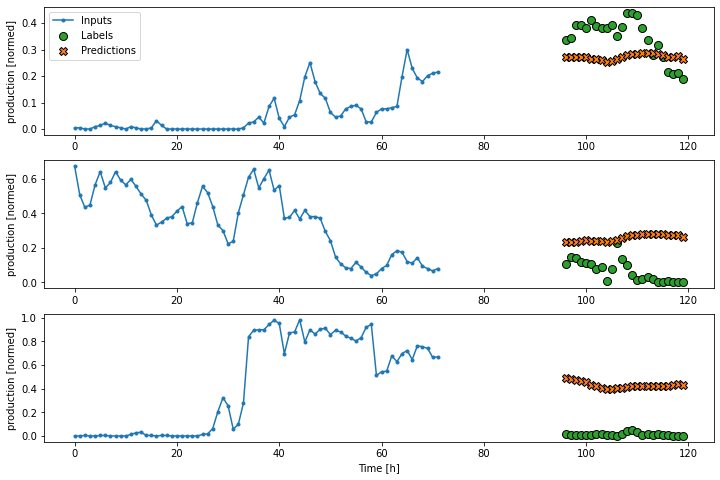

In [23]:
multi_linear_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    # tf.keras.layers.Dense(OUT_STEPS*num_features),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

multi_val_performance['Linear1'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear1'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)


Epoch 1/40
657/657 [==============================] - 1s 2ms/step - loss: 0.0998 - mean_absolute_error: 0.2651 - val_loss: 0.1397 - val_mean_absolute_error: 0.3118
Epoch 2/40
657/657 [==============================] - 1s 1ms/step - loss: 0.0973 - mean_absolute_error: 0.2626 - val_loss: 0.1302 - val_mean_absolute_error: 0.3059
Epoch 3/40
657/657 [==============================] - 1s 2ms/step - loss: 0.0969 - mean_absolute_error: 0.2624 - val_loss: 0.1336 - val_mean_absolute_error: 0.3079
Epoch 4/40
657/657 [==============================] - 1s 1ms/step - loss: 0.0970 - mean_absolute_error: 0.2625 - val_loss: 0.1436 - val_mean_absolute_error: 0.3129
Epoch 5/40
657/657 [==============================] - 1s 1ms/step - loss: 0.0965 - mean_absolute_error: 0.2618 - val_loss: 0.1342 - val_mean_absolute_error: 0.3081
Epoch 6/40
657/657 [==============================] - 1s 1ms/step - loss: 0.0965 - mean_absolute_error: 0.2621 - val_loss: 0.1258 - val_mean_absolute_error: 0.3045
Epoch 7/40
657/6

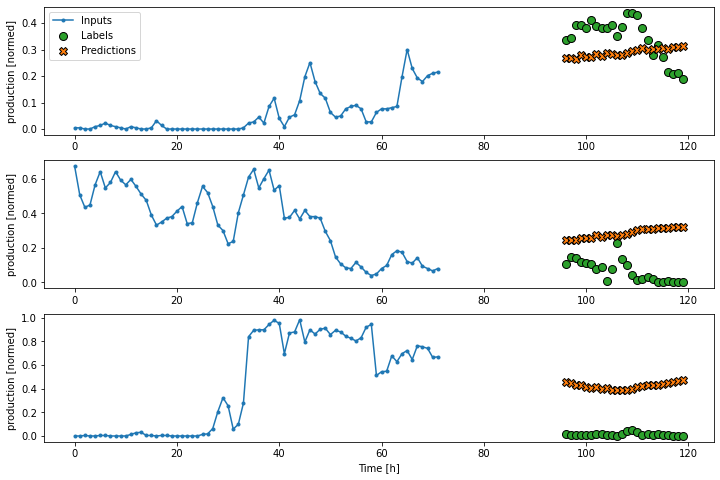

In [24]:
multi_linear_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Dense(OUT_STEPS*num_features),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

multi_val_performance['Linear2'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear2'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)


## Convolutional

Epoch 1/40
657/657 [==============================] - 1s 2ms/step - loss: 0.0987 - mean_absolute_error: 0.2640 - val_loss: 0.1248 - val_mean_absolute_error: 0.3025
Epoch 2/40
657/657 [==============================] - 1s 2ms/step - loss: 0.0955 - mean_absolute_error: 0.2604 - val_loss: 0.1222 - val_mean_absolute_error: 0.2954
Epoch 3/40
657/657 [==============================] - 1s 2ms/step - loss: 0.0946 - mean_absolute_error: 0.2589 - val_loss: 0.1138 - val_mean_absolute_error: 0.2928
Epoch 4/40
657/657 [==============================] - 1s 2ms/step - loss: 0.0937 - mean_absolute_error: 0.2576 - val_loss: 0.1186 - val_mean_absolute_error: 0.2944
Epoch 5/40
657/657 [==============================] - 1s 2ms/step - loss: 0.0933 - mean_absolute_error: 0.2568 - val_loss: 0.1109 - val_mean_absolute_error: 0.2898
Epoch 6/40
657/657 [==============================] - 1s 2ms/step - loss: 0.0928 - mean_absolute_error: 0.2561 - val_loss: 0.1126 - val_mean_absolute_error: 0.2898
Epoch 7/40
657/6

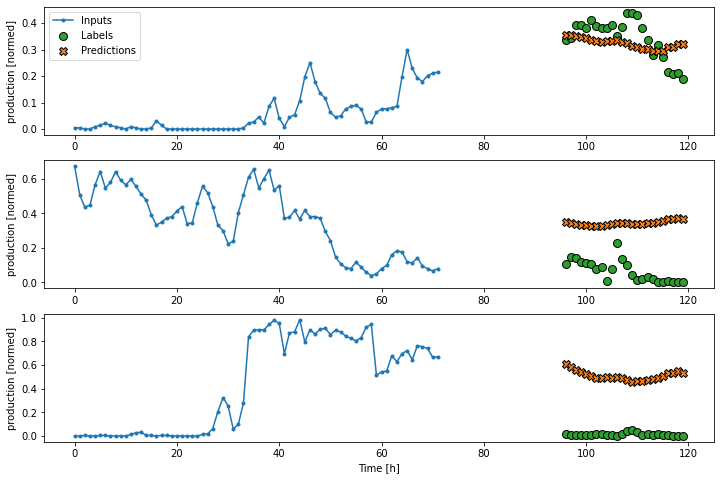

In [87]:
CONV_WIDTH = 7
multi_conv_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)
multi_val_performance['Conv1'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv1'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

Epoch 1/40
657/657 [==============================] - 2s 2ms/step - loss: 0.0997 - mean_absolute_error: 0.2654 - val_loss: 0.1190 - val_mean_absolute_error: 0.2985
Epoch 2/40
657/657 [==============================] - 1s 2ms/step - loss: 0.0958 - mean_absolute_error: 0.2607 - val_loss: 0.1218 - val_mean_absolute_error: 0.2987
Epoch 3/40
657/657 [==============================] - 1s 2ms/step - loss: 0.0945 - mean_absolute_error: 0.2586 - val_loss: 0.1153 - val_mean_absolute_error: 0.2964
Epoch 4/40
657/657 [==============================] - 1s 2ms/step - loss: 0.0937 - mean_absolute_error: 0.2575 - val_loss: 0.1156 - val_mean_absolute_error: 0.2923
Epoch 5/40
657/657 [==============================] - 1s 2ms/step - loss: 0.0925 - mean_absolute_error: 0.2556 - val_loss: 0.1156 - val_mean_absolute_error: 0.2920
Epoch 6/40
657/657 [==============================] - 1s 2ms/step - loss: 0.0920 - mean_absolute_error: 0.2544 - val_loss: 0.1196 - val_mean_absolute_error: 0.2960
Epoch 7/40
657/6

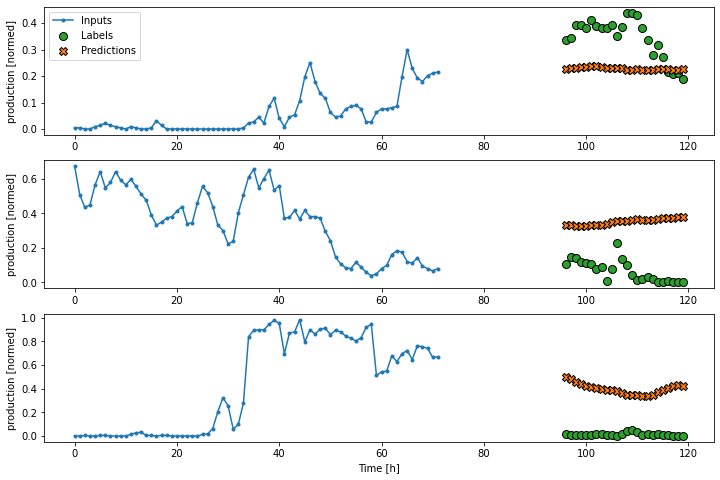

In [84]:
CONV_WIDTH = 7
multi_conv_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH), padding="same"),
    tf.keras.layers.Conv1D(64, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)
multi_val_performance['Conv2'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv2'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

Epoch 1/40
657/657 [==============================] - 2s 3ms/step - loss: 0.0996 - mean_absolute_error: 0.2650 - val_loss: 0.1311 - val_mean_absolute_error: 0.3103
Epoch 2/40
657/657 [==============================] - 2s 3ms/step - loss: 0.0955 - mean_absolute_error: 0.2603 - val_loss: 0.1226 - val_mean_absolute_error: 0.2970
Epoch 3/40
657/657 [==============================] - 2s 3ms/step - loss: 0.0937 - mean_absolute_error: 0.2576 - val_loss: 0.1202 - val_mean_absolute_error: 0.2972
Epoch 4/40
657/657 [==============================] - 2s 3ms/step - loss: 0.0927 - mean_absolute_error: 0.2559 - val_loss: 0.1190 - val_mean_absolute_error: 0.2970
Epoch 5/40
657/657 [==============================] - 2s 3ms/step - loss: 0.0919 - mean_absolute_error: 0.2543 - val_loss: 0.1315 - val_mean_absolute_error: 0.3042
Epoch 6/40
657/657 [==============================] - 2s 3ms/step - loss: 0.0911 - mean_absolute_error: 0.2529 - val_loss: 0.1335 - val_mean_absolute_error: 0.3039
Epoch 7/40
657/6

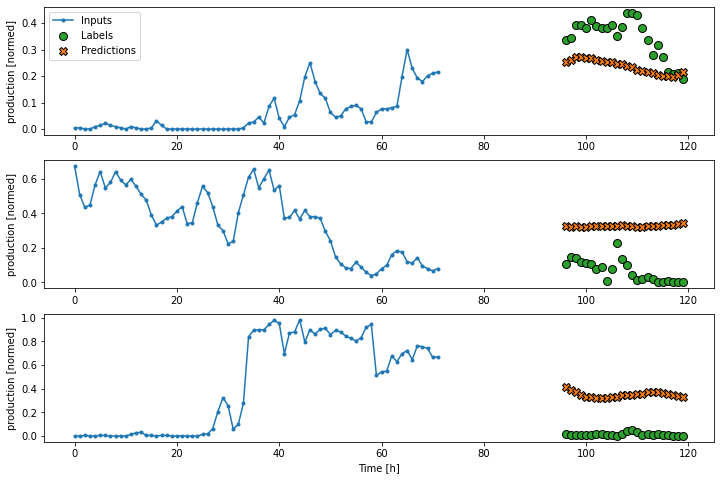

In [88]:
CONV_WIDTH = 12
multi_conv_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH), padding="same"),
    tf.keras.layers.Conv1D(64, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)
multi_val_performance['Conv3'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv3'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

Epoch 1/40
657/657 [==============================] - 4s 5ms/step - loss: 0.1004 - mean_absolute_error: 0.2660 - val_loss: 0.1203 - val_mean_absolute_error: 0.3032
Epoch 2/40
657/657 [==============================] - 3s 5ms/step - loss: 0.0951 - mean_absolute_error: 0.2593 - val_loss: 0.1139 - val_mean_absolute_error: 0.2990
Epoch 3/40
657/657 [==============================] - 3s 5ms/step - loss: 0.0927 - mean_absolute_error: 0.2552 - val_loss: 0.1111 - val_mean_absolute_error: 0.2912
Epoch 4/40
657/657 [==============================] - 3s 5ms/step - loss: 0.0906 - mean_absolute_error: 0.2515 - val_loss: 0.1250 - val_mean_absolute_error: 0.2940
Epoch 5/40
657/657 [==============================] - 3s 5ms/step - loss: 0.0885 - mean_absolute_error: 0.2478 - val_loss: 0.1119 - val_mean_absolute_error: 0.2864
Epoch 6/40
657/657 [==============================] - 3s 5ms/step - loss: 0.0869 - mean_absolute_error: 0.2451 - val_loss: 0.1219 - val_mean_absolute_error: 0.2938
Epoch 7/40
657/6

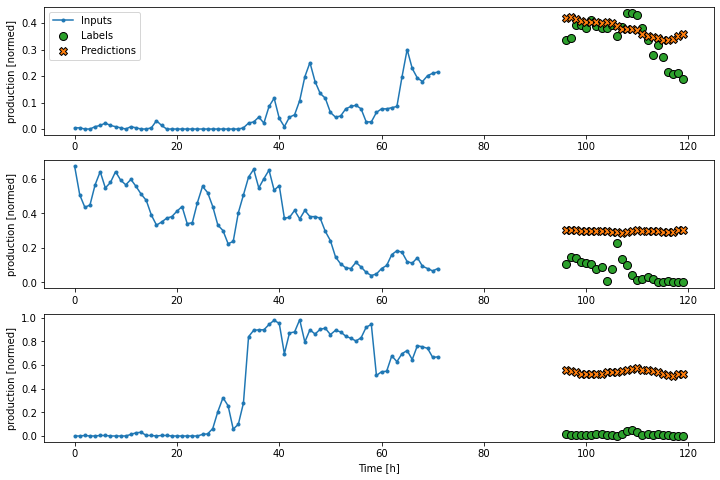

In [89]:
CONV_WIDTH = 24
multi_conv_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH), padding="same"),
    tf.keras.layers.Conv1D(64, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)
multi_val_performance['Conv4'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv4'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

Epoch 1/40
657/657 [==============================] - 7s 10ms/step - loss: 0.1026 - mean_absolute_error: 0.2673 - val_loss: 0.1518 - val_mean_absolute_error: 0.3160
Epoch 2/40
657/657 [==============================] - 7s 11ms/step - loss: 0.0960 - mean_absolute_error: 0.2611 - val_loss: 0.1488 - val_mean_absolute_error: 0.3170
Epoch 3/40
657/657 [==============================] - 7s 11ms/step - loss: 0.0938 - mean_absolute_error: 0.2575 - val_loss: 0.1390 - val_mean_absolute_error: 0.3086
Epoch 4/40
657/657 [==============================] - 7s 11ms/step - loss: 0.0914 - mean_absolute_error: 0.2538 - val_loss: 0.1380 - val_mean_absolute_error: 0.3147
Epoch 5/40
657/657 [==============================] - 7s 11ms/step - loss: 0.0906 - mean_absolute_error: 0.2521 - val_loss: 0.1296 - val_mean_absolute_error: 0.3028
Epoch 6/40
657/657 [==============================] - 7s 11ms/step - loss: 0.0884 - mean_absolute_error: 0.2480 - val_loss: 0.1302 - val_mean_absolute_error: 0.3005
Epoch 7/40

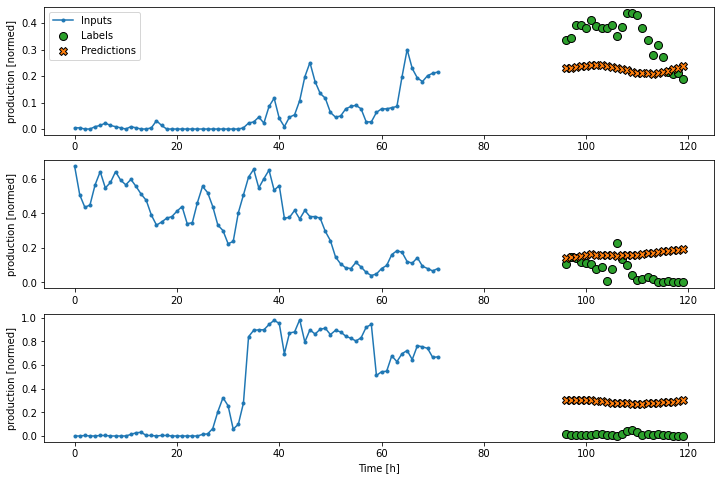

In [93]:
CONV_WIDTH = 24
multi_conv_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    tf.keras.layers.Conv1D(128, activation='relu', kernel_size=(CONV_WIDTH), padding="same"),
    tf.keras.layers.Conv1D(128, activation='relu', kernel_size=(CONV_WIDTH), padding="same"),
    tf.keras.layers.Conv1D(64, activation='relu', kernel_size=(CONV_WIDTH)), 
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)
multi_val_performance['Conv4'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv4'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

## RNN

Epoch 1/40
657/657 [==============================] - 10s 14ms/step - loss: 0.0995 - mean_absolute_error: 0.2662 - val_loss: 0.1272 - val_mean_absolute_error: 0.3079
Epoch 2/40
657/657 [==============================] - 8s 13ms/step - loss: 0.0920 - mean_absolute_error: 0.2554 - val_loss: 0.1306 - val_mean_absolute_error: 0.3073
Epoch 3/40
657/657 [==============================] - 8s 13ms/step - loss: 0.0882 - mean_absolute_error: 0.2492 - val_loss: 0.1290 - val_mean_absolute_error: 0.3114
Epoch 4/40
657/657 [==============================] - 9s 13ms/step - loss: 0.0860 - mean_absolute_error: 0.2450 - val_loss: 0.1312 - val_mean_absolute_error: 0.3136
Epoch 5/40
657/657 [==============================] - 9s 13ms/step - loss: 0.0833 - mean_absolute_error: 0.2399 - val_loss: 0.1321 - val_mean_absolute_error: 0.3091
Epoch 6/40
657/657 [==============================] - 9s 13ms/step - loss: 0.0790 - mean_absolute_error: 0.2321 - val_loss: 0.1358 - val_mean_absolute_error: 0.3165
Epoch 7/4

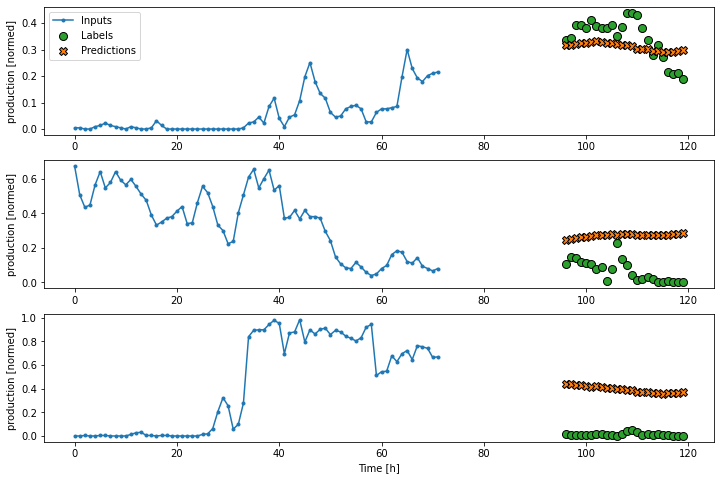

In [106]:
multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

multi_val_performance['RNN1'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['RNN1'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)


Epoch 1/40
657/657 [==============================] - 13s 18ms/step - loss: 0.0988 - mean_absolute_error: 0.2651 - val_loss: 0.1359 - val_mean_absolute_error: 0.3140
Epoch 2/40
657/657 [==============================] - 11s 17ms/step - loss: 0.0922 - mean_absolute_error: 0.2556 - val_loss: 0.1422 - val_mean_absolute_error: 0.3106
Epoch 3/40
657/657 [==============================] - 11s 17ms/step - loss: 0.0874 - mean_absolute_error: 0.2463 - val_loss: 0.1245 - val_mean_absolute_error: 0.2979
Epoch 4/40
657/657 [==============================] - 11s 17ms/step - loss: 0.0836 - mean_absolute_error: 0.2392 - val_loss: 0.1248 - val_mean_absolute_error: 0.2992
Epoch 5/40
657/657 [==============================] - 11s 17ms/step - loss: 0.0798 - mean_absolute_error: 0.2321 - val_loss: 0.1321 - val_mean_absolute_error: 0.3054
Epoch 6/40
657/657 [==============================] - 11s 17ms/step - loss: 0.0726 - mean_absolute_error: 0.2184 - val_loss: 0.1480 - val_mean_absolute_error: 0.3248
Epoc

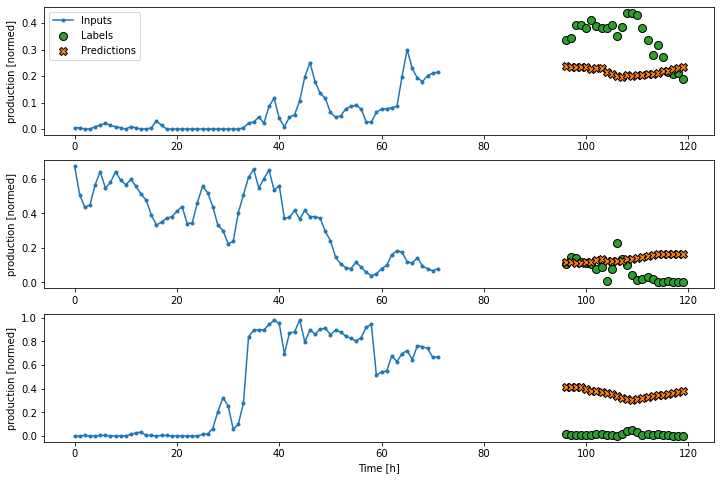

In [108]:
multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

multi_val_performance['RNN2'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['RNN2'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)


Epoch 1/40
657/657 [==============================] - 22s 31ms/step - loss: 0.1017 - mean_absolute_error: 0.2701 - val_loss: 0.1244 - val_mean_absolute_error: 0.3045
Epoch 2/40
657/657 [==============================] - 20s 30ms/step - loss: 0.0946 - mean_absolute_error: 0.2596 - val_loss: 0.1273 - val_mean_absolute_error: 0.3071
Epoch 3/40
657/657 [==============================] - 20s 30ms/step - loss: 0.0893 - mean_absolute_error: 0.2507 - val_loss: 0.1265 - val_mean_absolute_error: 0.3113
Epoch 4/40
657/657 [==============================] - 20s 31ms/step - loss: 0.0854 - mean_absolute_error: 0.2431 - val_loss: 0.1288 - val_mean_absolute_error: 0.3056
Epoch 5/40
657/657 [==============================] - 22s 34ms/step - loss: 0.0809 - mean_absolute_error: 0.2346 - val_loss: 0.1395 - val_mean_absolute_error: 0.3162
Epoch 6/40
657/657 [==============================] - 21s 32ms/step - loss: 0.0741 - mean_absolute_error: 0.2216 - val_loss: 0.1471 - val_mean_absolute_error: 0.3224
Epoc

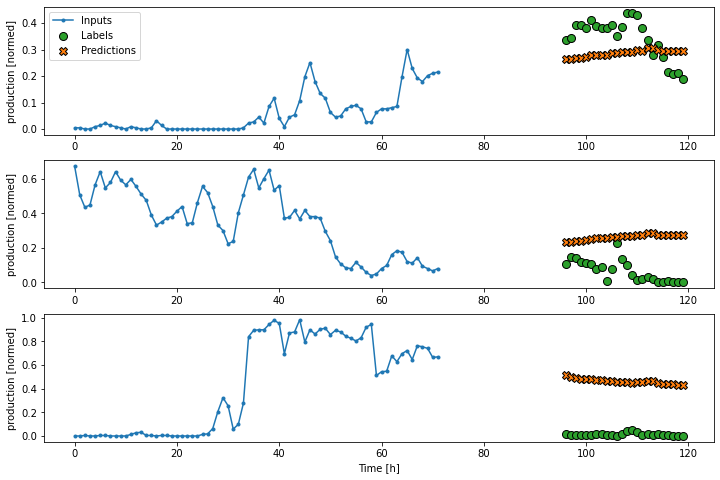

In [109]:
multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

multi_val_performance['RNN3'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['RNN3'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)


Epoch 1/40
657/657 [==============================] - 21s 28ms/step - loss: 0.1026 - mean_absolute_error: 0.2703 - val_loss: 0.1306 - val_mean_absolute_error: 0.3081
Epoch 2/40
657/657 [==============================] - 18s 27ms/step - loss: 0.0936 - mean_absolute_error: 0.2584 - val_loss: 0.1392 - val_mean_absolute_error: 0.3122
Epoch 3/40
657/657 [==============================] - 20s 30ms/step - loss: 0.0893 - mean_absolute_error: 0.2509 - val_loss: 0.1311 - val_mean_absolute_error: 0.3110
Epoch 4/40
657/657 [==============================] - 22s 34ms/step - loss: 0.0858 - mean_absolute_error: 0.2441 - val_loss: 0.1380 - val_mean_absolute_error: 0.3140
Epoch 5/40
657/657 [==============================] - 21s 32ms/step - loss: 0.0812 - mean_absolute_error: 0.2345 - val_loss: 0.1380 - val_mean_absolute_error: 0.3163
Epoch 6/40
657/657 [==============================] - 20s 31ms/step - loss: 0.0816 - mean_absolute_error: 0.2351 - val_loss: 0.1431 - val_mean_absolute_error: 0.3220
Epoc

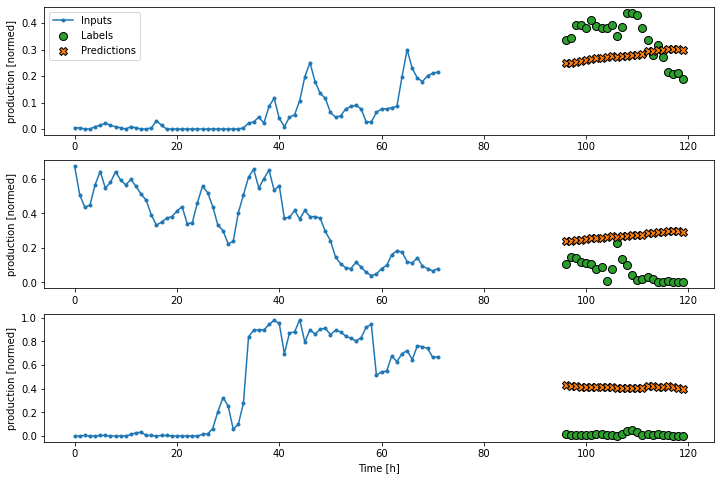

In [111]:
multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(16, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

multi_val_performance['RNN4'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['RNN4'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)


Epoch 1/40
657/657 [==============================] - 5s 5ms/step - loss: 0.1010 - mean_absolute_error: 0.2690 - val_loss: 0.1265 - val_mean_absolute_error: 0.3081
Epoch 2/40
657/657 [==============================] - 3s 5ms/step - loss: 0.0965 - mean_absolute_error: 0.2627 - val_loss: 0.1220 - val_mean_absolute_error: 0.3048
Epoch 3/40
657/657 [==============================] - 3s 5ms/step - loss: 0.0947 - mean_absolute_error: 0.2598 - val_loss: 0.1225 - val_mean_absolute_error: 0.3050
Epoch 4/40
657/657 [==============================] - 3s 5ms/step - loss: 0.0935 - mean_absolute_error: 0.2576 - val_loss: 0.1262 - val_mean_absolute_error: 0.3054
Epoch 5/40
657/657 [==============================] - 3s 5ms/step - loss: 0.0927 - mean_absolute_error: 0.2562 - val_loss: 0.1263 - val_mean_absolute_error: 0.3049
Epoch 6/40
657/657 [==============================] - 3s 5ms/step - loss: 0.0915 - mean_absolute_error: 0.2542 - val_loss: 0.1230 - val_mean_absolute_error: 0.3066
Epoch 7/40
657/6

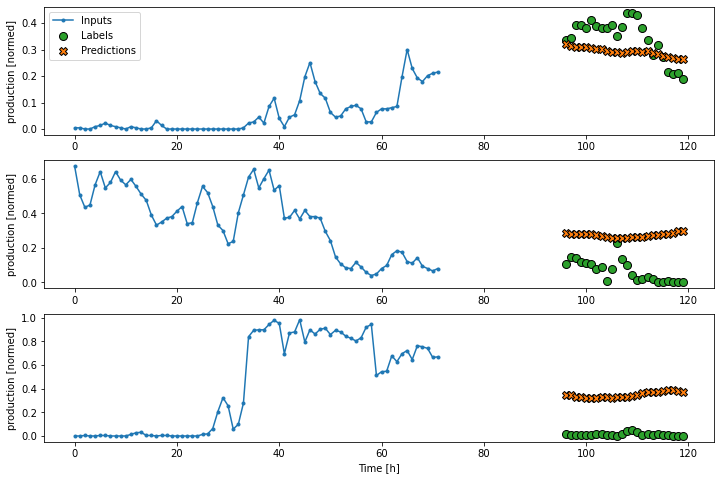

In [112]:
CONV_WIDTH = 12
multi_conv_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    tf.keras.layers.Conv1D(128, activation='relu', kernel_size=(CONV_WIDTH), padding="same"),
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features,kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

multi_val_performance['ConvLSTM1'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['ConvLSTM1'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

Epoch 1/40
657/657 [==============================] - 7s 7ms/step - loss: 0.1043 - mean_absolute_error: 0.2720 - val_loss: 0.1347 - val_mean_absolute_error: 0.3106
Epoch 2/40
657/657 [==============================] - 4s 6ms/step - loss: 0.0966 - mean_absolute_error: 0.2635 - val_loss: 0.1273 - val_mean_absolute_error: 0.3062
Epoch 3/40
657/657 [==============================] - 4s 5ms/step - loss: 0.0946 - mean_absolute_error: 0.2599 - val_loss: 0.1186 - val_mean_absolute_error: 0.3015
Epoch 4/40
657/657 [==============================] - 4s 5ms/step - loss: 0.0935 - mean_absolute_error: 0.2580 - val_loss: 0.1200 - val_mean_absolute_error: 0.2968
Epoch 5/40
657/657 [==============================] - 4s 5ms/step - loss: 0.0923 - mean_absolute_error: 0.2560 - val_loss: 0.1246 - val_mean_absolute_error: 0.2955
Epoch 6/40
657/657 [==============================] - 4s 6ms/step - loss: 0.0915 - mean_absolute_error: 0.2542 - val_loss: 0.1239 - val_mean_absolute_error: 0.2952
Epoch 7/40
657/6

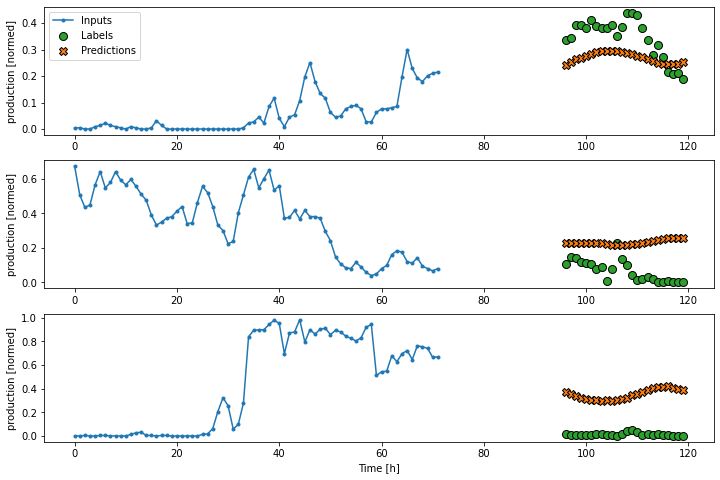

In [114]:
CONV_WIDTH = 12
multi_conv_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    tf.keras.layers.Conv1D(128, activation='relu', kernel_size=(CONV_WIDTH), padding="same"),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Conv1D(32, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.LSTM(16, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features,kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

multi_val_performance['ConvLSTM2'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['ConvLSTM2'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

In [118]:
def plot_metrics(sort_test=True):
    plt.figure(figsize=(12, 15))
    x = np.arange(len(multi_performance))
    width = 0.3
    
    for n in range(len(multi_linear_model.metrics_names)):
        plt.subplot(len(multi_linear_model.metrics_names), 1, n+1)
        metric_name = multi_linear_model.metrics_names[n]
        val_mae = [v[n] for v in multi_val_performance.values()]
        test_mae = [v[n] for v in multi_performance.values()]
        
        if sort_test:
            sorted_index = np.argsort(test_mae)
        else:
            sorted_index = np.argsort(val_mae)
        val_mae = [val_mae[i] for i in sorted_index]
        test_mae = [test_mae[i] for i in sorted_index]

        plt.bar(x - 0.17, val_mae, width, label='Validation')
        plt.bar(x + 0.17, test_mae, width, label='Test')
        plt.xticks(ticks=x, labels=[list(multi_performance.keys())[i] for i in sorted_index], rotation=45)
        plt.ylabel(metric_name)
        plt.title(metric_name)
        if n == 0:
            _ = plt.legend()

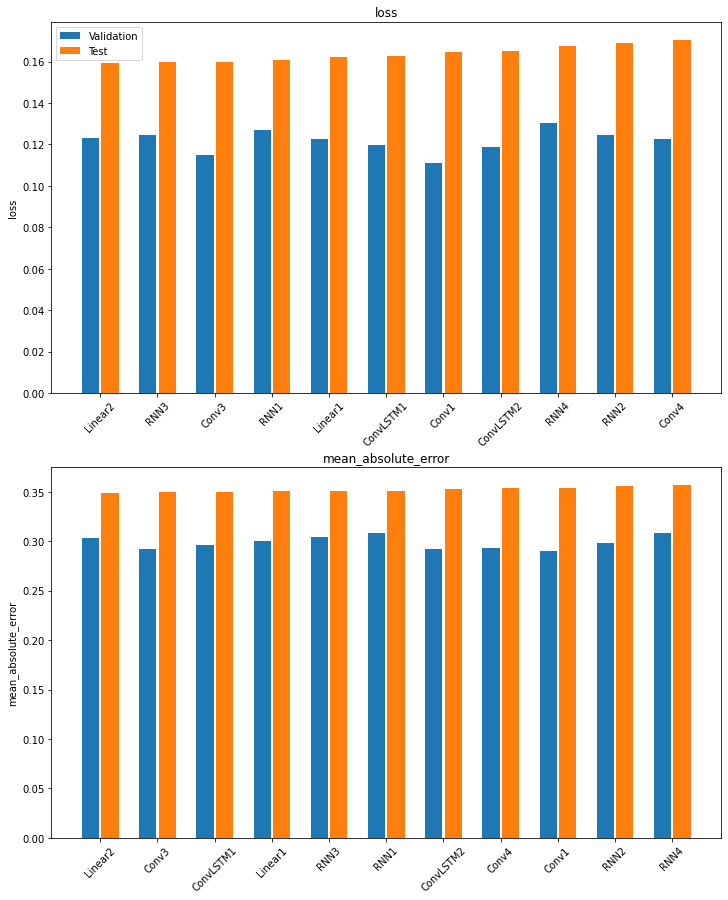

In [119]:
plot_metrics()

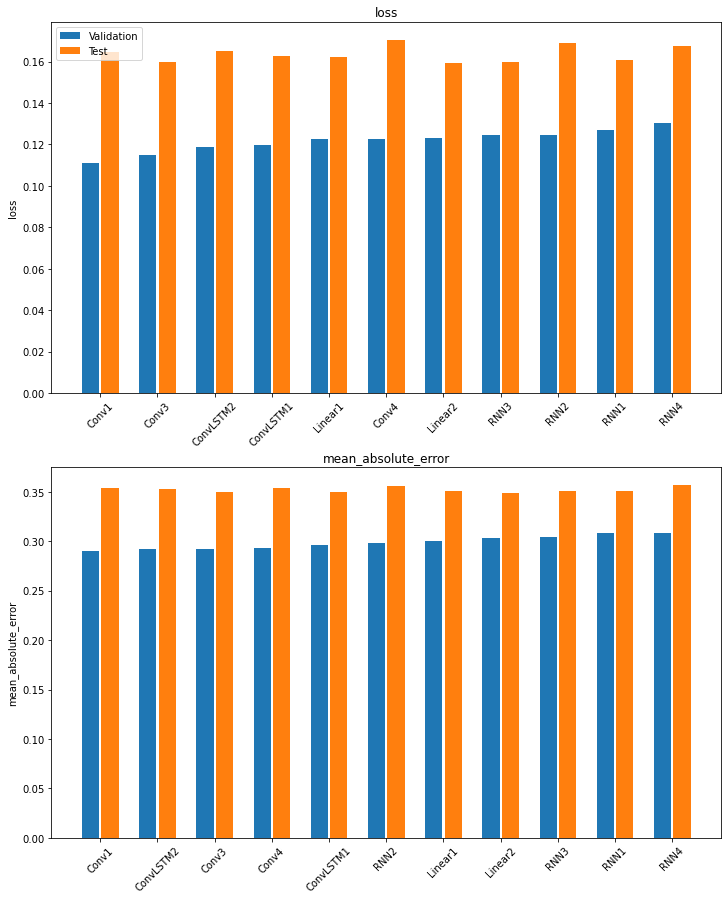

In [120]:
plot_metrics(False)

In [116]:
multi_performance

{'Linear1': [0.16219042241573334, 0.3505675494670868],
 'Linear2': [0.1591205596923828, 0.3492606580257416],
 'Conv1': [0.16460826992988586, 0.35422083735466003],
 'Conv3': [0.15967348217964172, 0.3494029641151428],
 'Conv4': [0.17042145133018494, 0.354071706533432],
 'RNN1': [0.16102416813373566, 0.35098594427108765],
 'RNN2': [0.168939009308815, 0.3560278117656708],
 'RNN3': [0.15961216390132904, 0.35057690739631653],
 'RNN4': [0.1674964725971222, 0.3571105897426605],
 'ConvLSTM1': [0.16255711019039154, 0.3502609431743622],
 'ConvLSTM2': [0.16510175168514252, 0.35245823860168457]}